In [1]:
"""Importowanie potrzebnych w projekcie bibliotek"""
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#Poniższa metoda to implementacja środków ciężkości z wykorzystaniem funkcji cv2.moments()
#W dalszej części kodu znajduje się implementacja z wykorzystaniem własnej metody
#
#def Moment_I(self):
#        Operator = self.binImage.copy()
#        M = cv2.moments(Operator)
#        cX = M["m10"] / M["m00"]
#        cY = M["m01"] / M["m00"]
#        return [cX, cY]

In [2]:
"""
Deklaracja klasy ImageShape zawierającej metody służące do badania współczynników kształtu figury na obrazie
baseImage - obraz bazowy (wejściowy)
grayImage - obraz po konwersji do skali szarości
binImage - obraz po binaryzacji OTSU
"""
class ImageShape:
    def __init__(self, srcImage):
        self.baseImage = srcImage.copy()
        self.grayImage = cv2.cvtColor(self.baseImage, cv2.COLOR_BGR2GRAY)
        (self.thr, self.binImage) = cv2.threshold(self.grayImage, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    """
    Implementacja metody tworzącej kontur na potrzeby obliczeń
    kernel - element strukturalny złożony z jedynek
    Ero - obraz zbinaryzowany po erozji
    Result - kontur obrazu (uzyskany przez odjęcie bazowego i erozji)
    """
    def makeContour(self):
        kernel = np.ones((3, 3), np.uint8)
        Ero = cv2.erode(self.binImage, kernel, iterations=1)
        Result = self.binImage.copy() - Ero
        return Result

    """
    Implementacja metody szukającej punktu startowego dla FCC
    """
    def getStartPos(self, srcImage):
        for i in range(srcImage.shape[0]):
            for j in range(srcImage.shape[1]):
                getVal = srcImage[i,j]
                if(0 < getVal):
                    startPosition = (i, j)
                    return startPosition

    """
    Implementacja FCC z poprzedniego laboratorium w celu obliczania obwodu figury
    """
    def Perimeter(self, srcImage):
        directions = [  5,  6,  7,
                        4,      0,
                        3,  2,  1]
        
        change_j =   [  -1,  0,  1,
                        -1,      1,
                        -1,  0,  1]
        
        change_i =   [  -1, -1, -1,
                         0,      0,
                         1,  1,  1]
        
        dir2idx = dict(zip(directions, range(len(directions))))
        start_point = self.getStartPos(srcImage)
        curr_point = start_point
        border = []
        chain = []
        for direction in directions:
            idx = dir2idx[direction]
            new_point = (start_point[0]+change_i[idx], start_point[1]+change_j[idx])
            if srcImage[new_point] != 0: # if is ROI
                border.append(new_point)
                chain.append(direction)
                curr_point = new_point
                break
        
        count = 0
        while curr_point != start_point:
            b_direction = (direction + 5) % 8 
            dirs_1 = range(b_direction, 8)
            dirs_2 = range(0, b_direction)
            dirs = []
            dirs.extend(dirs_1)
            dirs.extend(dirs_2)
            for direction in dirs:
                idx = dir2idx[direction]
                new_point = (curr_point[0]+change_i[idx], curr_point[1]+change_j[idx])
                if srcImage[new_point] != 0: # if is ROI
                    border.append(new_point)
                    chain.append(direction)
                    curr_point = new_point
                    break
            if count == 1000: break
            count += 1
        
        straight_lines = [0, 2, 4, 6]
        straight_count = 0
        curve_count = 0
        for l in chain:
            if l in straight_lines:
                straight_count += 1
            else:
                curve_count += 1
        
        return (straight_count + (curve_count*np.sqrt(2)))

    """
    Metoda wyliczająca wartości momentów I-go rzędu (środek ciężkości)
    SumPos - suma pozycji dla danej płaszczyzny X albo Y
    cX / cY - pozycje środka ciężkości w osi X oraz Y
    """
    def Moment_I(self):
        SumPosX = 0
        SumPosY = 0
        for i in range(self.binImage.shape[0]):
            for j in range(self.binImage.shape[1]):
                if(self.binImage[i,j] == 1):
                    SumPosX += j
                    SumPosY += i
        cX = (1/np.sum(self.binImage))*SumPosX
        cY = (1/np.sum(self.binImage))*SumPosY
        return [cX, cY]
    
    """
    Metoda wyliczająca wartości momentów II-go rzędu
    SumPos - sumy pozycji stosowane we wzorach dla momentów
    M2[X/Y/XY] - wynik dla momentów II-go rzędu
    """
    def Moment_II(self):
        [M1X, M1Y] = self.Moment_I()
        SumX = 0
        SumY = 0
        SumXY = 0
        for i in range(self.binImage.shape[0]):
            for j in range(self.binImage.shape[1]):
                if(self.binImage[i,j] == 1):
                    SumX += np.power((j - M1X),2)
                    SumY += np.power((i - M1Y),2)
                    SumXY += ((j - M1X)*(i - M1Y))

        M2X = (1/np.sum(self.binImage))*SumX
        M2Y = (1/np.sum(self.binImage))*SumY
        M2XY = (1/np.sum(self.binImage))*SumXY
        return [M2X, M2Y, M2XY]
    
    """
    Metoda wyliczająca współczynnik Fereta
    Szukane są skrajne pozycje pikseli na obrazie (oś X przeszukiwana w osi Y [góra - dół], a oś Y w osi X [lewo-prawo])
    Flaga - służy wyłącznie do kasowania pętli
    Lh/Lf_star/end - pozycje skrajne pikseli
    Lf/Lh - wysokość i szerokość obiektu
    Rf - wynik
    """
    def Feret_coefficient(self):
        Flag = False
        (Lh_start, Lh_end) = (0, 0)
        (Lf_start, Lf_end) = (0, 0)

        for i in range(self.binImage.shape[0]):
            for j in range(self.binImage.shape[1]):
                if(self.binImage[i,j] == 1):
                    Lf_start = i
                    Flag = True
                if(Flag == True):
                    break
            if(Flag == True):
                    break
            
        Flag = False
        for i in range(self.binImage.shape[0]-1, 0, -1):
            for j in range(self.binImage.shape[1]-1, 0, -1):
                if(self.binImage[i,j] == 1):
                    Lf_end = i
                    Flag = True
                if(Flag == True):
                    break
            if(Flag == True):
                    break
        
        Flag = False
        for i in range(self.binImage.shape[0]):
            for j in range(self.binImage.shape[1]):
                if(self.binImage[j,i] == 1):
                    Lh_start = i
                    Flag = True
                    if(Flag == True):
                        break
                if(Flag == True):
                    break

        Flag = False
        for i in range(self.binImage.shape[0]-1, 0, -1):
            for j in range(self.binImage.shape[1]-1, 0, -1):
                if(self.binImage[j,i] == 1):
                    Lh_end = i
                    Flag = True
                    if(Flag == True):
                        break
                if(Flag == True):
                    break

        Lh = np.abs((Lh_end-Lh_start))
        Lf = np.abs((Lf_end - Lf_start))
        Rf = (Lh/Lf)
        return Rf
    
    """
    Metoda wyliczająca współczynniki cyrkularności
    S - pole (suma pikseli na obrazie)
    L - obwód wyliczony przy pomocy FreemanChainCode
    """
    def Circle_coefficient(self):
        S = np.sum(self.binImage)
        L = self.Perimeter(self.binImage)
        RC1 = 2 * np.sqrt((S/np.pi))
        RC2 = L/np.pi
        return [RC1, RC2]
    
    """
    Metoda wyliczająca współczynnik malinowskiej
    L - obwód wyliczony przy pomocy FreemanChainCode
    S - pole (suma pikseli na obrazie)
    """
    def Malinowska_coefficient(self):
        L = self.Perimeter(self.binImage)
        S = np.sum(self.binImage)
        RM = (L/(2*np.sqrt(np.pi*S)))-1
        return RM
    
    """
    Metoda wyliczająca bezwymiarowy współczynnik kształtu
    L - obwód wyliczony przy pomocy FreemanChainCode
    S - pole (suma pikseli na obrazie)
    """
    def Dimensionless_Shape_Factor(self):
        L = self.Perimeter(self.binImage)
        S = np.sum(self.binImage)
        RS = np.power(L,2)/(4*np.pi*S)
        return RS
        
    """
    Metoda wyliczająca zwartość obiektu
    P - obwód wyliczony przy pomocy FreemanChainCode
    S - pole (suma pikseli na obrazie)
    """
    def Compactness(self):
        P = self.Perimeter(self.binImage)
        S = np.sum(self.binImage)
        Result = (4*np.pi*S)/np.power(P,2)
        return Result
    
    """
    Metoda wyliczająca krągłość obiektu
    S - pole (suma pikseli na obrazie)
    cX/cY - środek ciężkości
    Rmax - maksymalna odległość danego piksela od środka ciężkości (wyliczona pitagorasem)
    """
    def Roundness(self):
        S = np.sum(self.binImage)
        [cX, cY] = self.Moment_I()
        Operator = self.makeContour()
        Rmax = 0

        for i in range(Operator.shape[0]):
            for j in range(Operator.shape[1]):
                if(Operator[i,j] == 1):
                    Xdist = np.abs(j - cX)
                    Ydist = np.abs(i - cY)
                    Dist = np.sqrt((np.power(Xdist,2) + np.power(Ydist,2)))
                    if(Dist > Rmax):
                        Rmax = Dist

        P = S/(np.pi * np.power(Rmax,2))
        return P
    
    """
    Metoda wyliczająca współczynnik blaira-blissa
    S - pole (suma pikseli na obrazie)
    cX/cY - środek ciężkości
    RiSum - suma odległości danego piksela od środka ciężkości (wyliczana sumą pitagorasów)
    """
    def Blair_Bliss(self):
        S = np.sum(self.binImage)
        [cX, cY] = self.Moment_I()
        RiSum = 0

        for i in range(self.binImage.shape[0]):
            for j in range(self.binImage.shape[1]):
                if(self.binImage[i,j] == 1):
                    Xdist = np.abs(j - cX)
                    Ydist = np.abs(i - cY)
                    Dist = np.sqrt((np.power(Xdist,2) + np.power(Ydist,2)))
                    RiSum += np.power(Dist,2)

        Rbb = S / (np.sqrt(2 * np.pi * RiSum))
        return Rbb

    """
    Metoda wyliczająca współczynnik Haralicka
    Contour - kontur badanego kształtu
    cX/cY - środek ciężkości
    DiSum/DiSumPower - sumy odległości danego piksela konturu od środka ciężkości (sumy pitagorasów)
    """
    def Haralick(self):
        Contour = self.makeContour()
        n = np.sum(Contour)
        [cX, cY] = self.Moment_I()
        (DiSum, DiSumPower) = (0, 0)

        for i in range(self.binImage.shape[0]):
            for j in range(self.binImage.shape[1]):
                if(Contour[i,j] == 1):
                    Xdist = np.abs(j - cX)
                    Ydist = np.abs(i - cY)
                    Dist = np.sqrt((np.power(Xdist,2) + np.power(Ydist,2)))
                    DiSum += Dist
                    DiSumPower += np.power(Dist,2)

        Rh = np.sqrt(np.power(DiSum,2) / (n*DiSumPower-1))
        return Rh

    """
    Metoda wyliczająca współczynnik danielssona
    S - pole (suma pikseli)
    Contour - kontur figury
    InsideCntr - obiekt bez kontury (wnętrze)
    MaxDist - maksymalny możliwy dystans
    VecContour/VecInsideCntr - wektory pozycji, które będą badane
    """
    def Danielsson(self):
        S = np.sum(self.binImage)

        SumI = 0
        Contour = self.makeContour()
        InsideCntr = self.binImage.copy() - Contour
        MaxDist = np.sqrt(np.power(self.binImage.shape[0],2) + np.power(self.binImage.shape[1],2))

        VecContour = []
        VecInsideCntr = []

        for i in range(self.binImage.shape[0]):
            for j in range(self.binImage.shape[1]):
                if (1 == Contour[i,j]):
                    VecContour.append([i,j])
                if (1 == InsideCntr[i,j]):
                    VecInsideCntr.append([i,j])

        for ins in VecInsideCntr:
            LowDist = MaxDist
            for cont in VecContour:
                Ydist = np.abs(ins[0] - cont[0])
                Xdist = np.abs(ins[1] - cont[1])
                Dist_XY = np.sqrt((np.power(Xdist,2) + np.power(Ydist,2)))
                if(Dist_XY < LowDist):
                    LowDist = Dist_XY
            SumI += LowDist

        RD = np.power(S,3) / np.power(SumI,2)
        return RD
        
        

In [3]:
def PrintResults(OperateImg):
    plt.figure()
    plt.subplot(211)
    plt.imshow(OperateImg.binImage, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

    plt.subplot(212)
    Results = []
    Titles = []

    Results.append(OperateImg.Moment_I())
    Results.append(OperateImg.Moment_II())
    Results.append(OperateImg.Feret_coefficient())
    Results.append(OperateImg.Circle_coefficient())
    Results.append(OperateImg.Malinowska_coefficient())
    Results.append(OperateImg.Dimensionless_Shape_Factor())
    Results.append(OperateImg.Compactness())
    Results.append(OperateImg.Roundness())
    Results.append(OperateImg.Blair_Bliss())
    Results.append(OperateImg.Haralick())
    #Results.append(OperateImg.Danielsson())

    Titles.append("Momenty I-go rzędu")
    Titles.append("Momenty II-go rzędu")
    Titles.append("Współczynnik Fereta")
    Titles.append("Współczynniki Cyrkularności")
    Titles.append("Współczynnik Malinowskiej")
    Titles.append("Bezwymiarowy współczynnik kształtu")
    Titles.append("Zwartość")
    Titles.append("Krągłość")
    Titles.append("Współczynnik Blaira-Blissa")
    Titles.append("Współczynnik Haralicka")
    #Titles.append("Współczynnik Danielssona")
    
    Tex = pd.DataFrame({"Obliczone wartości": Results})
    Tex.index = Titles
    Table = plt.table(cellText = Tex.values, rowLabels = Tex.index, colLabels = Tex.columns, cellLoc="center", loc="center")
    plt.axis('off')

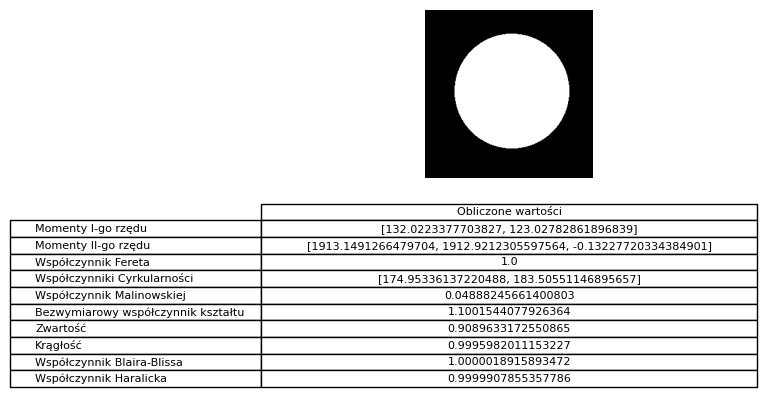

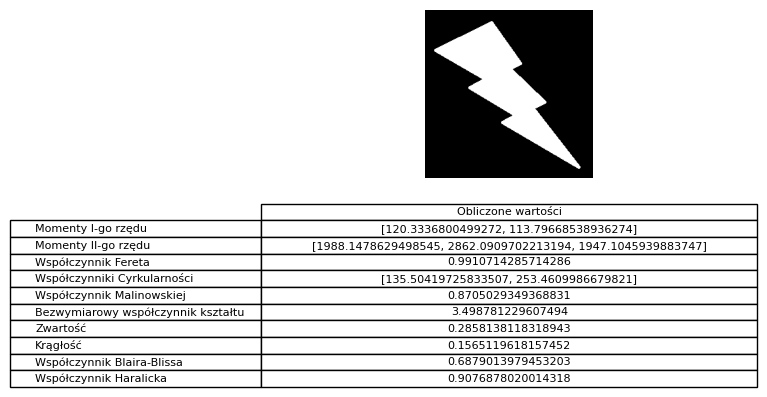

In [4]:
Image1 = ImageShape(cv2.imread("./circleMedium.bmp"))
Image2 = ImageShape(cv2.imread("./pierun.bmp"))

PrintResults(Image1)
PrintResults(Image2)